In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras as K
import tensorflow as tf
import cv2
import sys
import os
import torch
import torchvision
import matplotlib.patches as patches
from sklearn.metrics import accuracy_score,mean_squared_error 
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array,array_to_img, load_img
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
#from skimage.transform import resize
#from livelossplot import PlotLossesKeras
from chitra.image import Chitra
from torch import nn
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from imageai.Detection import ObjectDetection

In [8]:
df = pd.read_csv('./Dataset/train/Image_Data/Faces/bbox_train.csv')
df_Face = pd.read_csv('./Dataset/train/train.csv')
df

,Name,width,height,xmin,ymin,xmax,ymax
0,10001.jpg,612,408,192,199,230,235
1,10001.jpg,612,408,247,168,291,211
2,10001.jpg,612,408,321,176,366,222
3,10001.jpg,612,408,355,183,387,214
4,10002.jpg,612,408,339,165,378,202
...,...,...,...,...,...,...,...
24528,18205.jpg,612,425,9,52,52,116
24529,18207.jpg,475,612,160,149,241,226
24530,18207.jpg,475,612,226,47,277,104
24531,18207.jpg,475,612,113,41,179,106


# Create Darknet Format

In [21]:
for i in df['Name'].unique():
    df_temp = df[df['Name']==i]
    for index, row in df_temp.iterrows():
        with open("./Dataset/train/image_data/Faces/" + i[:-3] + 'txt', "a+") as file_object:
            # If file is not empty then append '\n'
            if os.stat("./Dataset/train/image_data/Faces/" + i).st_size != 0:
                file_object.write("\n")
            # Append text at the end of file
            file_object.write('0 '+str(np.mean([row['xmin'], row['xmax']])/row['width']) + ' ' + str((row['xmax']-row['xmin'])/ row['width']) + ' ' +str(np.mean([row['ymin'], row['ymax']])/row['height']) + ' ' + str((row['ymax']-row['ymin'])/ row['height'])) 

In [26]:
X = df_Face['Name']
y = df_Face['HeadCount']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.1, test_size = 0.03, random_state=10)

In [ ]:
for index,(i) in enumerate(X_train):
    with open("./Dataset/train/image_data/Faces/train.txt","a") as f:
        if index !=1:
            f.write("\n")
            f.write(i)
        else:
            f.write(i)

# Load and Resize Image

In [4]:
df = pd.read_csv('./Dataset/train/train.csv')
df_box = pd.read_csv('./Dataset/train/Box_Data/bbox_train.csv')
#Y = df.drop('Name', axis=1)
df_box_single = df_box.drop_duplicates(subset=['Name'])

In [5]:
df_box_single['Category'] = 1
df_box_single.drop(['width','height'], axis = 1,inplace=True)
df_box_single

/var/folders/nl/g8256hnj7d31zb_rcxg2746w0000gn/T/ipykernel_51752/1591401047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_box_single['Category'] = 1
/var/folders/nl/g8256hnj7d31zb_rcxg2746w0000gn/T/ipykernel_51752/1591401047.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_box_single.drop(['width','height'], axis = 1,inplace=True)


,Name,xmin,ymin,xmax,ymax,Category
0,10001.jpg,192,199,230,235,1
4,10002.jpg,339,165,378,202,1
8,10003.jpg,54,6,253,196,1
10,10004.jpg,138,191,218,267,1
13,10006.jpg,176,159,224,205,1
...,...,...,...,...,...,...
24511,18201.jpg,324,154,391,217,1
24513,18203.jpg,23,180,67,223,1
24516,18204.jpg,310,120,353,168,1
24521,18205.jpg,1,65,26,147,1


In [6]:
data = []
labels = []
bboxes = [np.array(df_box_single[['xmin','ymin','xmax','ymax']])]
imagePaths = []

In [7]:
bboxes = bboxes[0]
bboxes[0]

array([192, 199, 230, 235])

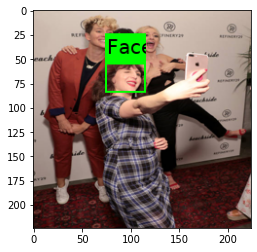

In [8]:
PATH = './Dataset/train/image_data/Faces/'
size = (224,224)
im_name = []
train_data = []
box_data = []
for  i,(name) in enumerate(df['Name']):
    image = Chitra(PATH + name, bboxes[i], 'Face')
    image.resize_image_with_bbox((224, 224))
    if image.numpy().shape != (224,224,3):
        df.drop(df[df['Name'] == name].index, inplace=True)
        continue
    train_data.append(image.numpy())
    temp = []
    temp.append([image.bboxes[0][0][0],image.bboxes[0][0][1],image.bboxes[0][1][0],image.bboxes[0][1][1]])
    box_data.append(temp[0])
    im_name.append(name)
train_data = np.array(train_data)
imgplot = plt.imshow(image.draw_boxes())
imgplot

# Pytorch-Yolo/Keras Resnet Aproach 

In [74]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5x', pretrained=True)

# Images
imgs = ['https://ultralytics.com/images/zidane.jpg']  # batch of images




Using cache found in /Users/sebastianbott/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-9-12 Python-3.10.5 torch-1.12.1 CPU

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


In [76]:
model.train()

AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 80, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1

In [ ]:
model(X_train)

In [31]:
result = model(imgs)

In [34]:
result.show()

In [9]:
X=train_data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,df['HeadCount'], train_size=0.8, test_size = 0.2, random_state=10)
y_test

772      4
3344     7
3332    24
596      4
4546    10
        ..
3879     3
2409     3
754      3
3660     3
283      5
Name: HeadCount, Length: 1145, dtype: int64

In [48]:
# Inference
Faces = []
for i,(pic) in enumerate(X_test):
    results = model(X_test[i])
    df_result = results.pandas().xyxy[0]
    Faces.append(df_result['name'][df_result['class']==0].count())

In [49]:
mean_squared_error(Faces,y_test,squared=False)

1.8695444649834403

In [55]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  # 1 class (person) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model=model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01)

/Users/sebastianbott/miniforge3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/sebastianbott/miniforge3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/sebastianbott/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [63]:
X_test_tensor = torchvision.transforms.ToTensor(X_train[0])
X_test_tensor

TypeError: ToTensor.__init__() takes 1 positional argument but 2 were given

In [62]:
X_train[0].shape

(224, 224, 3)

In [72]:
model.train()

TypeError: Module.type() missing 1 required positional argument: 'dst_type'

In [90]:
model = K.models.load_model('./yolo.h5')

In [ ]:
model.summary()

In [95]:
model.compile(optimizer='Adam', metrics=['accuracy'])

In [98]:
pred = model.predict(X_test)

2022-09-12 07:48:02.467128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 3s 277ms/step


In [73]:
input_t = K.Input(shape=(224, 224, 3))
res_model = K.applications.ResNet50 (include_top=True, weights="imagenet", input_tensor=input_t)
for layer in res_model.layers[:145]:
    layer.trainable = True

Metal device set to: Apple M1 Pro


2022-09-08 12:22:48.008898: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-08 12:22:48.009033: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [130]:
input_shape = (224, 224, 3)
input_layer = K.layers.Input(input_shape)
res_layer = res_model(input_layer)
train_layer = K.layers.Flatten()(res_layer)
train_layer = K.layers.BatchNormalization()(train_layer)
train_layer = K.layers.Dense(226, activation='relu')(train_layer)

classifier_branch = K.layers.Flatten()(train_layer)
classifier_branch = K.layers.BatchNormalization()(classifier_branch)
classifier_branch = K.layers.Dense(128, activation='relu', name='cl_1')(classifier_branch)
classifier_branch = K.layers.Dense(1, name='cl_head')(classifier_branch) 

locator_branch = K.layers.Flatten()(train_layer)
locator_branch = K.layers.BatchNormalization()(locator_branch)
locator_branch = K.layers.Dense(128, activation='relu', name='bb_1')(locator_branch)
locator_branch = K.layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = K.layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = K.layers.Dense(4, activation='relu', name='bb_head')(locator_branch)

In [131]:
model = tf.keras.Model(input_layer, outputs=[classifier_branch,locator_branch])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 1000)         25636712    ['input_9[0][0]']                
                                                                                                  
 flatten_10 (Flatten)           (None, 1000)         0           ['resnet50[6][0]']               
                                                                                                  
 batch_normalization_10 (BatchN  (None, 1000)        4000        ['flatten_10[0][0]']       

In [132]:
losses = {"cl_head":K.losses.categorical_crossentropy, "bb_head":K.losses.MSE}

In [133]:
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])

In [95]:
#face_model.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], optimizer='Adam', loss = 'binary_crossentropy' )

In [199]:
df

,Name,HeadCount
0,10001.jpg,4
1,10002.jpg,4
2,10003.jpg,2
3,10004.jpg,3
4,10006.jpg,4
...,...,...
5728,18201.jpg,2
5729,18203.jpg,3
5730,18204.jpg,5
5731,18205.jpg,8


In [96]:
X = train_data
y = np.array(box_data)
print(X.shape)
print(y.shape)

(5725, 224, 224, 3)
(5725, 4)


In [97]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.1, test_size = 0.03, random_state=10)
X_train.shape

(572, 224, 224, 3)

In [115]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(572, 224, 224, 3)
(172, 224, 224, 3)
(572, 4)
(172, 4)


In [83]:
checkpoint = K.callbacks.ModelCheckpoint("./Models/best_small_model.h5", save_best_only=True, monitor="val_loss"),

In [82]:
trainTargets = {
    "cl_head": df_box_single['Category'][0:571],
    "bb_head": y_train
}
validationTargets = {
    "cl_head": df_box_single['Category'][0:171],
    "bb_head": y_test
}

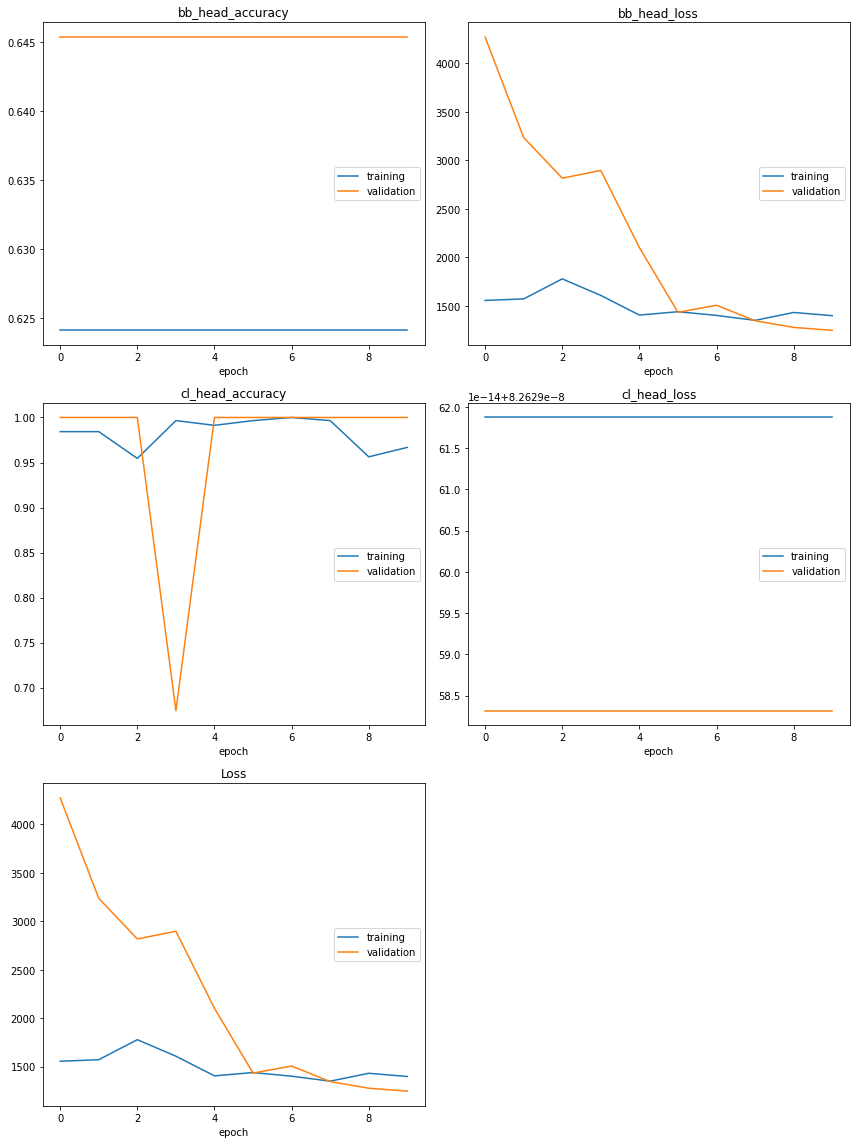

bb_head_accuracy
	training         	 (min:    0.624, max:    0.624, cur:    0.624)
	validation       	 (min:    0.645, max:    0.645, cur:    0.645)
bb_head_loss
	training         	 (min: 1350.495, max: 1778.377, cur: 1398.774)
	validation       	 (min: 1247.626, max: 4272.167, cur: 1247.626)
cl_head_accuracy
	training         	 (min:    0.955, max:    1.000, cur:    0.967)
	validation       	 (min:    0.674, max:    1.000, cur:    1.000)
cl_head_loss
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min: 1350.495, max: 1778.377, cur: 1398.774)
	validation       	 (min: 1247.626, max: 4272.167, cur: 1247.626)
36/36 [==============================] - 12s 325ms/step - loss: 1398.7743 - cl_head_loss: 8.2630e-08 - bb_head_loss: 1398.7743 - cl_head_accuracy: 0.9668 - bb_head_accuracy: 0.6241 - val_loss: 1247.6259 - val_cl_head_loss: 8.2630e-08 - val_bb_head_loss: 1247.6259 - val_cl_he

In [151]:
history = model.fit(X_train, [df_box_single['Category'][0:572],y_train],
             validation_data=(X_test, [df_box_single['Category'][0:172],y_test]),
             batch_size=16,
             epochs=10,
             shuffle=True,
             verbose=1,
             callbacks = [PlotLossesKeras(),checkpoint])

In [ ]:
pred = model.predict(X_test)
pred

In [159]:
bound = [ 99.360855,  63.495235, 125.062096, 105.99143 ],

In [182]:
image = Chitra(X_test[1], [bound, y_test[1]], ['Face','Face'])
# Chitra can rescale your bounding box automatically based on the new image size.
imgplot = plt.imshow(image.draw_boxes())
imgplot

TypeError: BoundingBox.__init__() missing 2 required positional arguments: 'x2' and 'y2'

rescaled bbox: [BoundingBox(x1=147.5033, y1=84.0000, x2=162.5098, y2=115.2941, label=Face)]


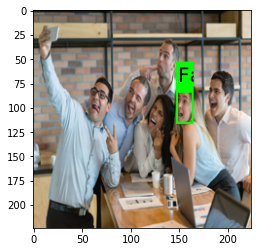

In [183]:
image = Chitra(X_test[1], y_test[1], 'Face')
# Chitra can rescale your bounding box automatically based on the new image size.
image.resize_image_with_bbox((224, 224))

print('rescaled bbox:', image.bboxes)
#plt.image(image.draw_boxes())
imgplot = plt.imshow(image.draw_boxes())
imgplot

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X,df['HeadCount'], train_size=0.1, test_size = 0.03, random_state=10)
y_test

772      4
3344     7
3332    24
596      4
4546    10
        ..
5309     4
5189     4
1976     3
3015     3
856      2
Name: HeadCount, Length: 172, dtype: int64

In [156]:
class facedataset(torch.utils.data.Dataset):
    def __init__(self,root,folder='train/image_data/Faces',transforms=None):
        self.transforms=[]
        if transforms!=None:
            self.transforms.append(transforms)
        self.root=root
        self.folder=folder
        box_data=pd.read_csv(os.path.join(root, "train/image_data/Faces/bbox_train.csv"))
        self.box_data = box_data
         #self.box_data=pd.concat([box_data,box_data.bbox.str.split('[').str.get(1).str.split(']').str.get(0).str.split(',',expand=True)],axis=1)
        self.imgs=list(os.listdir(os.path.join(root, self.folder)))
    def __len__(self):
        return len(self.imgs)
        
    def __getitem__(self,idx):
        img_path=os.path.join(os.path.join(self.root,self.folder),self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        df=self.box_data
        if df.shape[0]!=0:
            boxes = df[df['Name']== self.imgs[idx]]
            boxes = boxes.drop(['Name','width','height'], axis=1)
            labels= np.ones(len(boxes))
        else:
            boxes=np.asarray([[0,0,0,0]])
            labels=np.ones(len(boxes))
        for i in self.transforms:
            img=i(img)
            
        targets={}
        targets['boxes']= torch.from_numpy(boxes.values).float()
        targets['labels']=torch.from_numpy(labels).float()
       # targets['id']=self.box_data['Name']
        return img.double(),targets

In [157]:
root='./Dataset/'
dataset=facedataset(root,'train/image_data/Faces',transforms=torchvision.transforms.ToTensor())

In [158]:
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset_train = torch.utils.data.Subset(dataset, indices[:-6000])
dataset_test = torch.utils.data.Subset(dataset, indices[-6000:-5000])
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=8, shuffle=True,collate_fn=lambda x:list(zip(*x)))
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=8, shuffle=False,collate_fn=lambda x:list(zip(*x)))

In [159]:
torch.has_mps

True

2


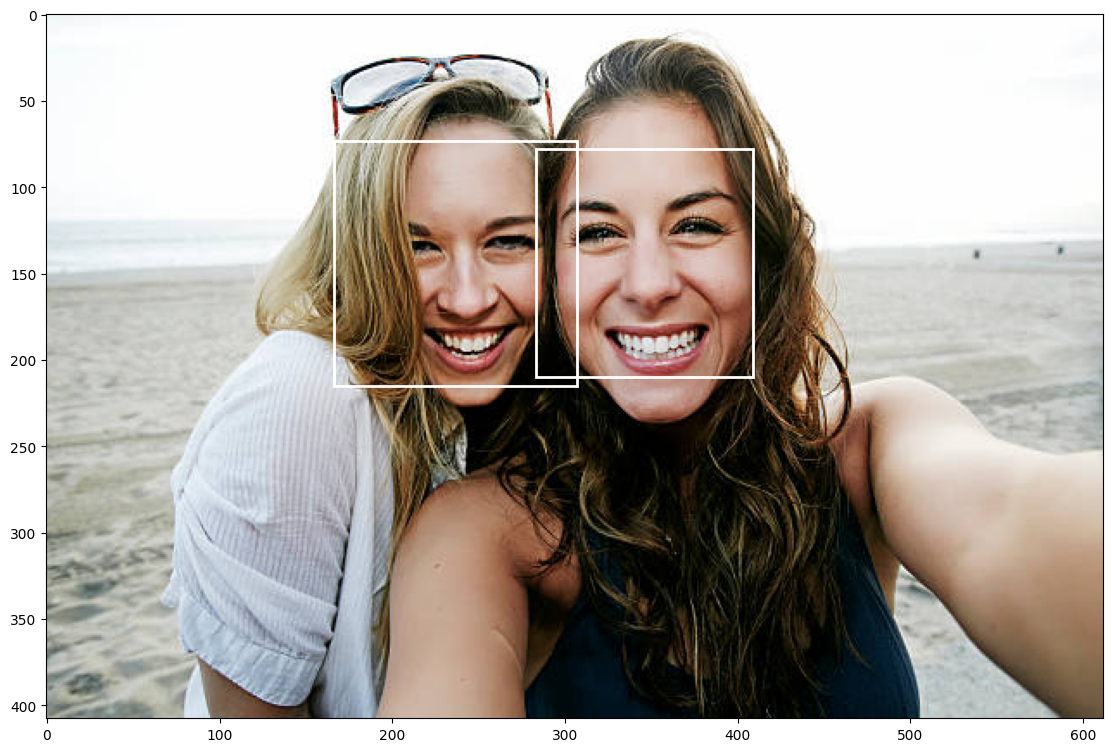

In [160]:
images,labels=next(iter(data_loader_train))
print(len(labels[0]['boxes']))
from matplotlib import patches
def view(images,labels,k,std=1,mean=0):
    figure = plt.figure(figsize=(30,30))
    images=list(images)
    labels=list(labels)
    for i in range(k):
        out=torchvision.utils.make_grid(images[i])
        inp=out.cpu().numpy().transpose((1,2,0))
        inp=np.array(std)*inp+np.array(mean)
        inp=np.clip(inp,0,1)  
        ax = figure.add_subplot(2,2, i + 1)
        ax.imshow(images[i].cpu().numpy().transpose((1,2,0)))
        l=labels[i]['boxes'].cpu().numpy()
        l[:,2]=l[:,2]-l[:,0]
        l[:,3]=l[:,3]-l[:,1]
        for j in range(len(l)):
            ax.add_patch(patches.Rectangle((l[j][0],l[j][1]),l[j][2],l[j][3],linewidth=2,edgecolor='w',facecolor='none')) 
view(images,labels,1)

In [161]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
device = torch.device('cpu')
num_classes = 2  # 1 class (person) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model=model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01)

In [ ]:
model.train()
for i in range(1):
    print('Starting Batch ' + str(i))
    for images,targets in tqdm(data_loader_train):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        model=model.double()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()

        optimizer.zero_grad
        optimizer.step()

        print("Loss = {:.4f} ".format(losses.item()))

    torch.save(model.state_dict(), './model.pth')

Starting Batch 0


  0%|          | 0/275 [00:00<?, ?it/s]

[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument



systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


In [ ]:
torch.cuda.is_available()

In [ ]:
from torch.utils.tensorboard import SummaryWriter
global loss_fn
loss_fn = torch.nn.CrossEntropyLoss()

running_loss = 0.
last_loss = 0.

# Here, we use enumerate(training_loader) instead of
# iter(training_loader) so that we can track the batch
# index and do some intra-epoch reporting
for i,( inputs,labels) in enumerate(data_loader_train):
    # Every data instance is an input + label pair
    #inputs, labels = data
    # Zero your gradients for every batch!
    optimizer.zero_grad()

    # Make predictions for this batch
    try:
        outputs = model(inputs)
    except:
        print(inputs)
        break
    # Compute the loss and its gradients
    loss = loss_fn(outputs, labels)
    loss.backward()

    # Adjust learning weights
    optimizer.step()

    # Gather data and report
    running_loss += loss.item()
    if i % 1000 == 999:
        last_loss = running_loss / 1000 # loss per batch
        print('  batch {} loss: {}'.format(i + 1, last_loss))
        tb_x = 1 * len(training_loader) + i + 1
        SummaryWriter.add_scalar('Loss/train', last_loss, tb_x)
        running_loss = 0.



In [54]:
model.train()
train_one_epoch(1,SummaryWriter)

(tensor([[[0.8353, 0.8314, 0.8157,  ..., 0.7059, 0.7490, 0.7765],
         [0.8314, 0.8235, 0.8000,  ..., 0.7098, 0.7529, 0.7804],
         [0.8314, 0.8157, 0.7804,  ..., 0.7059, 0.7529, 0.7765],
         ...,
         [0.1373, 0.1725, 0.1922,  ..., 0.6863, 0.6627, 0.6471],
         [0.1529, 0.1569, 0.1725,  ..., 0.7647, 0.7569, 0.7529],
         [0.1647, 0.1451, 0.1569,  ..., 0.8275, 0.8196, 0.8196]],

        [[0.8667, 0.8627, 0.8510,  ..., 0.7529, 0.7961, 0.8275],
         [0.8706, 0.8667, 0.8431,  ..., 0.7569, 0.8039, 0.8314],
         [0.8863, 0.8706, 0.8392,  ..., 0.7529, 0.8039, 0.8275],
         ...,
         [0.1255, 0.1608, 0.1804,  ..., 0.9098, 0.9098, 0.9098],
         [0.1412, 0.1451, 0.1608,  ..., 0.9529, 0.9569, 0.9608],
         [0.1529, 0.1333, 0.1451,  ..., 0.9647, 0.9765, 0.9765]],

        [[0.8235, 0.8118, 0.7843,  ..., 0.6745, 0.7020, 0.7098],
         [0.8275, 0.8118, 0.7765,  ..., 0.6784, 0.7020, 0.7137],
         [0.8353, 0.8118, 0.7647,  ..., 0.6667, 0.7020, 0

UnboundLocalError: local variable 'outputs' referenced before assignment

# CV2 Approach

In [164]:
#face_model.fit(X_train,y_train,batch_size=16,epochs = 10,verbose = 1, validation_data = (X_test,y_test),callbacks=[PlotLossesKeras(),checkpoint])

In [ ]:
detector.loadModel()
detections = detector.detectObjectsFromImage(input_image=os.path.join(execution_path , "/Users/sebastianbott/Documents/Development/Competitions/Competition_Face_Count/Dataset/train/image_data/Faces/17737.jpg"), output_image_path=os.path.join(execution_path , "./Dataset/train/image_data/Boxed/10001.jpg"))



In [ ]:
for batch in train_datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='', save_format='jpeg'):
    i += 1
    if i > 20:
        break